# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Jakub Kuzník xkuzni04_

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [3]:
def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    for line in f:
        line = line.decode("utf-8")

        # In loaded line it will get rid of spaces 
        # and line ends symbols 
        line = line.replace(" ", "")
        line = line.replace("\n", "")
        
        # Split string before and after delimeter into two 
        split_string = line.split(":")

        # Match first string and store the second one into dict.
        # !! We are even storying not SUCCESS status.
        if split_string[0] == "Configuration":
            data["conf"] = split_string[1]
        elif split_string[0] == "Run":
            data["run"] = split_string[1]
        elif split_string[0] == "Timeofrun":
            data["time"] = float(split_string[1])
        
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
            
df = pd.DataFrame(data)
df


,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

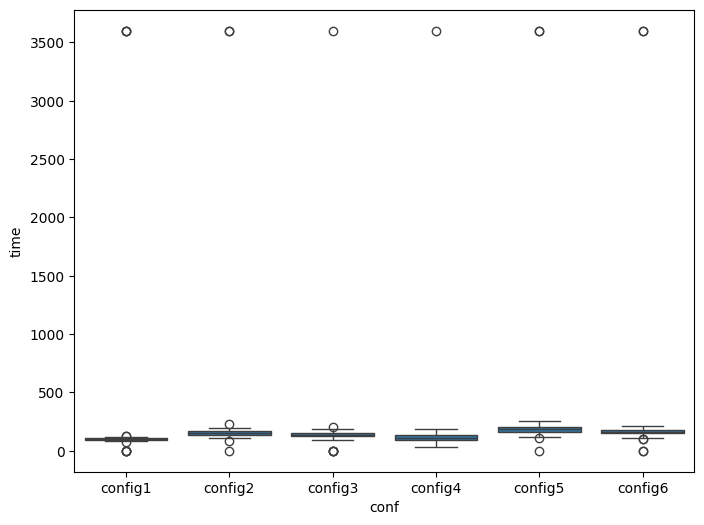

In [4]:
df = pd.DataFrame(data)

plt.figure(figsize=(8,6))

# Get name of all configs 
# [config1, config2, ... ]
unique_configs = df['conf'].unique()

sns.boxplot(x='conf', y='time', data=df)

#df
plt.show()

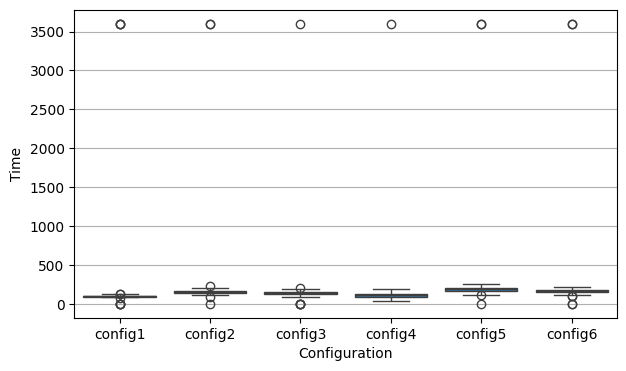

In [5]:
df = pd.DataFrame(data)

# We are using subplots for easier work with x,y labels 
fig, ax = plt.subplots(figsize=(7,4))
plt.grid(True)

# For each configuration -> 
#   do boxplot 
sns.boxplot(x='conf', y='time', data=df)

# Set axis labels 
ax.set(xlabel="Configuration", ylabel="Time")
plt.show()



__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_


  Boxplot nám ukazuje očekávané minimum (max(min(X), Q1 – 1.5 * (Q3-Q1))) a očekávané maximum (analogicky k minimu) pro jednotlivé konfigurace. Vidíme, že na grafu existují hodnoty, které nespadají do těchto očekávaných rozsahů. Tyto hodnoty jsou zobrazeny jako kroužky.

Odchylky, blížící se k času 0: 
  Na první pohled se tyto odchylky nemusí jevit jako vážný problém, ale je třeba mít na paměti, že čas nemůže být záporný. Pokud se čas blíží k nule, může to naznačovat, že se proces vlastně nepodařilo spustit.

Odchylky, blížící se k času 3600:
  Tyto odchylky jsou velmi výrazné. Vzhledem k tomu, že všechny tyto odchylky mají stejnou výšku, můžeme předpokládat, že jde o nějaký maximální časový limit, po němž je proces ukončen.



Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

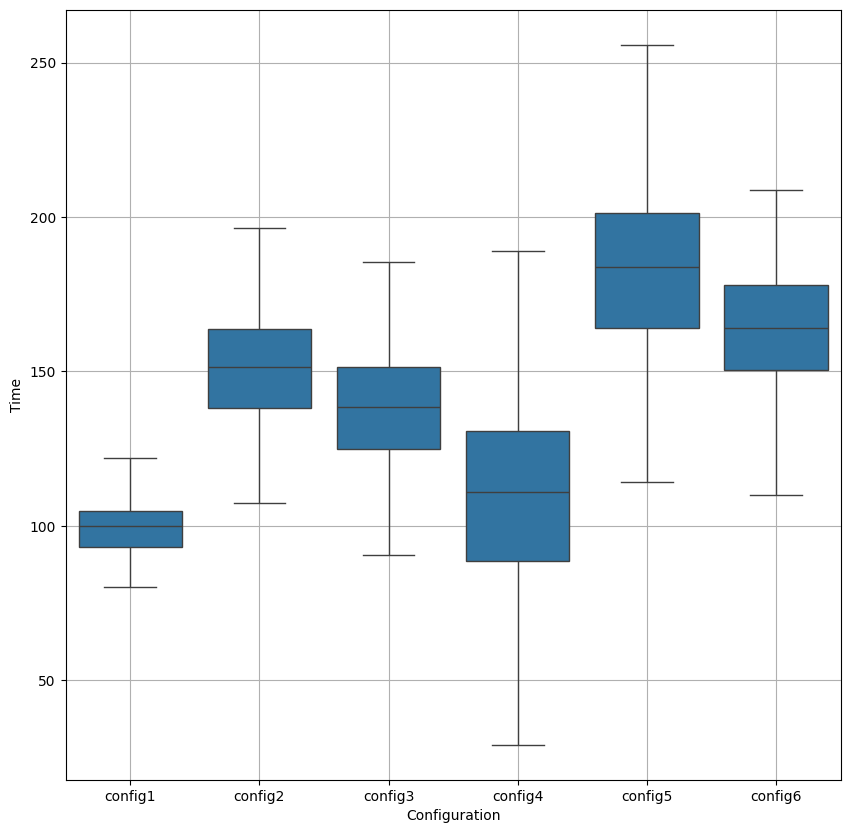

In [5]:
df = pd.DataFrame(data)

# Create array where we will be inserting filtered data 
#   for each configuration.
df_filtered_array = []

# Find all the unique configuration in data 
unique_configs = df['conf'].unique()

# iterate throught config names 
for name in unique_configs:
    # get subframe of data matching one config 
    one_df = df[df['conf'] == str(name)]

    # Count quantils, using formula from lecture 
    q_up = one_df['time'].quantile(0.75) 
    q_down = one_df['time'].quantile(0.25) 
    IQR = q_up - q_down
    min = q_down - 1.5 * IQR
    max = q_up + 1.5 * IQR

    # Create a boolean mask for rows to be removed
    mask_upper = one_df['time'] < max
    mask_bottom = one_df['time'] > min
    
    # combine masks 
    mask_combined = mask_upper & mask_bottom

    # append filtered data 
    df_filtered_array.append(one_df[mask_combined])

## Put filtered data into the data frame 
df_filtered = pd.concat(df_filtered_array, ignore_index=True)

# plot 
plt.figure(figsize=(10,10))
plt.xlabel('Configuration')
plt.ylabel('Time')
sns.boxplot(x='conf', y='time', data=df_filtered)
plt.grid(True)
plt.show()



## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [6]:
group = df_filtered.groupby('conf')

pd.DataFrame(group['time'].describe())


,count,mean,std,min,25%,50%,75%,max
conf,,,,,,,,
config1,190.0,99.449016,8.866788,80.124311,93.034540,99.799944,104.737728,121.904556
config2,195.0,151.688034,18.583050,107.522086,138.003905,151.516091,163.764042,196.293171
config3,194.0,138.292420,19.393682,90.567110,124.769359,138.448002,151.501348,185.413857
config4,199.0,110.317016,30.656816,29.093401,88.742158,110.782732,130.665606,188.971462
config5,196.0,184.049441,28.276656,114.035821,164.072975,183.916111,201.255548,255.807973
config6,194.0,163.450775,19.817267,110.011886,150.325780,164.185319,177.846198,208.795048


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

Count (Počet): Tato hodnota udává, kolik záznamů je k dispozici pro každou konfiguraci.

Mean (Průměr): Průměrná hodnota pro každou konfiguraci. 

Std (Směrodatná odchylka): Udává měřítko variability dat. Směrodatná odchylka pro "config1" je přibližně 8.87. Čím vyšší hodnota směrodatné odchylky, tím více jsou data rozptýlena od průměrné hodnoty, tedy v případě normálního rozdělení je gaussova křivka více zploštělá.

Min (Minimum): Nejmenší hodnota v datasetu pro každou konfiguraci. 

25% (První kvartil): Hodnota, pod kterou spadá čtvrtina dat.

50% (Medián): Medián je střední hodnota datasetu, což znamená, že 50% dat leží nad ním a 50% dat leží pod ním.

75% (Třetí kvartil): Hodnota, pod kterou spadá tři čtvrtiny dat. 

Max (Maximum): Největší hodnota v datasetu pro každou konfiguraci. 

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

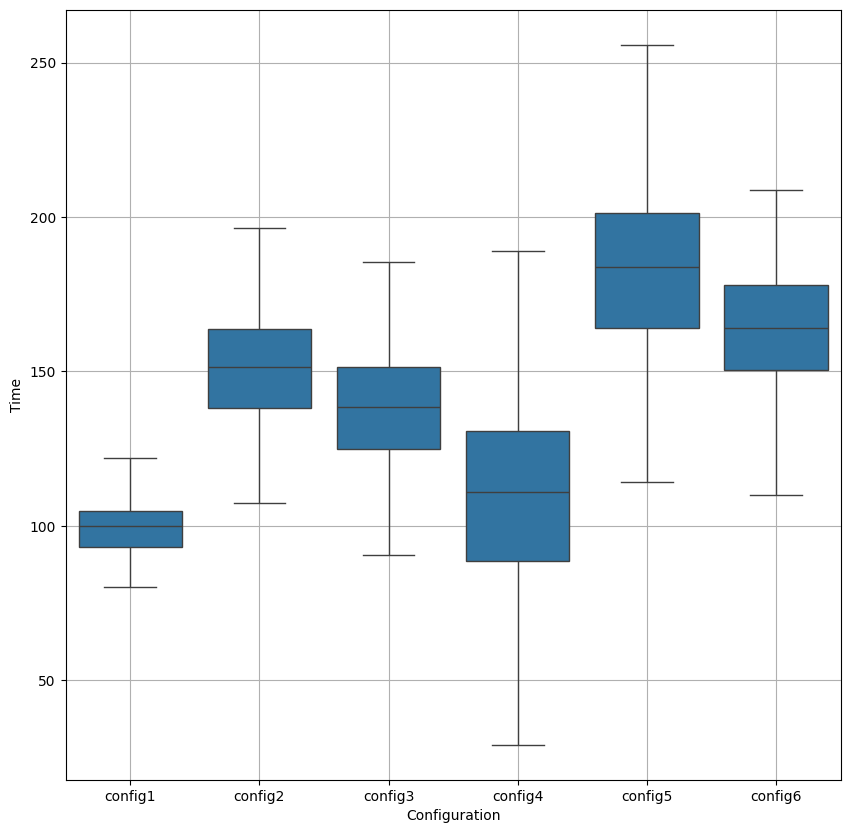

In [7]:
# Vyuzijeme stejny typ grafu jako v predchozi uloze  
plt.figure(figsize=(10,10))
plt.xlabel('Configuration')
plt.ylabel('Time')
sns.boxplot(x='conf', y='time', data=df_filtered)
plt.grid(True)
plt.show()


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte výsledky z tabulky._

Na grafu máme boxploty, pro jednotlivé konfigurace. Modrá obdélníková část boxplotu ukazuje rozsah dat mezi prvním kvartilem (Q1) a třetím kvartilem (Q3), což je oblast, kde se nachází středních 50% dat, tzv IQR (Interquatile Range). Přičemž čim vyšší je box (obdelník) na ose 'y' tím větší směrodatnou odchylku dat máme, tedy tím více jsou data royptýlená od středu. 

Čára uprostřed boxu: Tato čára v boxu reprezentuje medián, což je střední hodnota dat.

Vodorovné čáry (vousy) označují rozsah ve, kterém se nachází všechna data, ten odpovídá: (Q1-1.5*IQ, Q3+1.5*IQR). 

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Zkoumáme data týkající se konfigurací config1 a config4. Zdá se, že config1 má lepší střední hodnotu, zatímco config4 má vyšší rozptyl. Na první pohled však nedokážeme říci, který config je lepší.

Zvolený test
- Pro srovnání těchto konfigurací používáme Dvouvýběrový t-test, při kterém bereme v úvahu, že hodnoty jsou nezávislé a rozptyly jsou různé.

Nulová hypotéza
- Nulová hypotéza, kterou testujeme, tvrdí, že tyto dvě konfigurace mají stejné průměrné hodnoty. To by znamenalo, že neexistuje žádný statisticky významný rozdíl mezi časy běhu konfigurace 1 a konfigurace 4.

Poloha konfigurací
- Pokud jde o polohu vybraných konfigurací, konkrétně statistiky jako medián, průměr a vyšší kvantily, vypadají lépe pro config1. Na druhé straně, nižší kvantily jsou výhodnější pro config4.

Variabilita konfigurací
- config4 má jasně větší variabilitu, tedy data jsou více roztahaná. Ať už jde o IQR, či rozptyl. 

In [39]:
# Get the pandas of configurations 
data_config1 = df_filtered[df_filtered['conf'] == 'config1']
data_config4 = df_filtered[df_filtered['conf'] == 'config4']

# Get the pure data of configuration (time) 
time_config1 = data_config1['time'].to_numpy()
time_config4 = data_config4['time'].to_numpy()

### !!!
# assuming the null hypothesis, that the samples are 
# drawn from populations with the same population means, is true. 
print("Hypothesis: Samples are from the data with same mean")

# We are also considering different variance. 
t_statistic, p_value = stats.ttest_ind(time_config1, time_config4, equal_var=False)

# Determine which group has a smaller mean
significance_level = 0.05  # significance level
if p_value < significance_level:

    # Therefore, the statistic will be positive when the sample mean of a is greater
    # than the sample mean of b and negative when the sample mean of a is less than the sample mean of b.
    print("Hypothesis proof to be wrong.")
    print("There is statistical difference between config1 and config4 on 0.05 significance level.")
    if (t_statistic > 0):
        print("config4 is faster.")
    else:
        print("config1 is faster.")

else:
    print("Hypothesis proof to be right.")
    print("There is no statisticall difference between config1 and config4 on 0.05 significance level.")

Hypothesis: Samples are from the data with same mean
Hypothesis proof to be wrong.
There is statistical difference between config1 and config4 on 0.05 significance level.
config1 is faster.


__OTÁZKA K DOPLNĚNÍ:__

Závěr statistického testu je, že jsme s mírou věrohodnosti 0.05 rozhodli, že je config4 rychlejší. 

In [38]:
# sample mean
X1 = np.mean(time_config1)
X4 = np.mean(time_config4)

# sample variance 
S1 = np.var(time_config1)
S4 = np.var(time_config4)

# Number of samples 
N1 = len(time_config1)
N4 = len(time_config4)

## HELP VARIABLES 
A1 = S1/N1
A4 = S4/N4
B1 = 1/(N1-1)
B4 = 1/(N4-1)
C1 = A1**2
C4 = A4**2

# T value 
T = (X1-X4)/np.sqrt((A1)+(A4))

# Degrees of freedom 
V = ((A1+A4)**2) / ((B1*C1)+(B4*C4))

## now we need table of values t1-a where we will find p-value 
# Calculate the p-value
p_value = 2 * (1 - stats.t.cdf(np.abs(T), df=V))  


##### SAME CODE AS ABOVE 
### !!!
# assuming the null hypothesis, that the samples are 
# drawn from populations with the same population means, is true. 
print("Hypothesis: Samples are from the data with same mean")

# Determine which group has a smaller mean
significance_level = 0.05  # significance level
if p_value < significance_level:

    # Therefore, the statistic will be positive when the sample mean of a is greater
    # than the sample mean of b and negative when the sample mean of a is less than the sample mean of b.
    print("Hypothesis proof to be wrong.")
    print("There is statistical difference between config1 and config4 on 0.05 significance level.")
    if (T > 0):
        print("config4 is faster.")
    else:
        print("config1 is faster.")

else:
    print("Hypothesis proof to be right.")
    print("There is no statisticall difference between config1 and config4 on 0.05 significance level.")


Hypothesis: Samples are from the data with same mean
Hypothesis proof to be wrong.
There is statistical difference between config1 and config4 on 0.05 significance level.
config1 is faster.
